# Behavioural Planning for Autonomous Highway Driving

We plan a trajectory using the _Optimistic Planning for Deterministic systems_ ([OPD](https://hal.inria.fr/hal-00830182)) algorithm.

##  Setup

We first import useful modules for the environment, agent, and visualization.

In [1]:
import gym
import sys
sys.path.append("/home/baiming/highway_multiagent_env") 
sys.path.append("C://Users//baiming//Seafile//THUFile//Papers//highway_env_multiagent") 
import highway_env

from agent import Agent

import torch
from torch import optim
import numpy as np 

from tqdm import tnrange
# from utils import record_videos,  capture_intermediate_frames

import argparse
import torch
import time
import os
import numpy as np
from gym.spaces import Box, Discrete
from pathlib import Path
from torch.autograd import Variable
from tensorboardX import SummaryWriter
# from utils.make_env import make_env
from utils.buffer import ReplayBuffer
# from utils.env_wrappers import SubprocVecEnv, DummyVecEnv
from algorithms.maddpg import MADDPG


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
#     plt.subplot(132)
#     plt.title('frame %s. loss: %s' % (frame_idx, losses[-1]))
#     plt.plot(losses)
    plt.show()

In [4]:
model_dir = Path('./models') 
run_dir = model_dir 
log_dir = run_dir / 'logs10'
os.makedirs(log_dir)
logger = SummaryWriter(str(log_dir))

torch.manual_seed(12)
np.random.seed(12)
env = gym.make("intersection-multiagent-v0")
# print(env.action_space, env.observation_space)
maddpg = MADDPG.init_from_env(env, agent_alg='DDPG',
                              adversary_alg='DDPG',
                              tau=0.01,
                              lr=0.01,
                              hidden_dim=64)
replay_buffer = ReplayBuffer(int(1e6), maddpg.nagents,
                             [obsp.shape[0] for obsp in env.observation_space],
                             [acsp.shape[0] if isinstance(acsp, Box) else acsp.n
                              for acsp in env.action_space])

/home/baiming/anaconda3/envs/highway/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


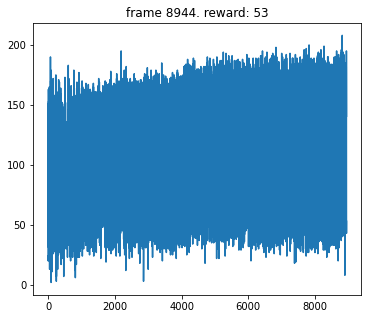

KeyboardInterrupt: 

In [5]:
t = 0
returns = []
for ep_i in range(25000):
#     print("Episodes %i-%i of %i" % (ep_i + 1,
#                                     ep_i + 2,
#                                     200))
    obs = env.reset()
    # obs.shape = (n_rollout_threads, nagent)(nobs), nobs differs per agent so not tensor
    maddpg.prep_rollouts(device='gpu')
    
    explr_pct_remaining = max(0, 20000 - ep_i) / 20000
    maddpg.scale_noise(0.3 * explr_pct_remaining)
    maddpg.reset_noise()
    
    sum_reward = 0

    agent_obs = []
    for i in range(4):
        agent_obs.append(np.array([obs[i%4], obs[(i+1)%4], obs[(i+2)%4], obs[(i+3)%4]]).flatten())
    obs = np.array([agent_obs])

    for et_i in range(100):
#         print(obs)
        torch_obs = [torch.FloatTensor(np.vstack(obs[:, i])) for i in range(maddpg.nagents)]
#         print(torch_obs)
        torch_agent_actions = maddpg.step(torch_obs, explore=True)
        # convert actions to numpy arrays
        agent_actions = [ac.data.numpy() for ac in torch_agent_actions]
        # rearrange actions to be per environment
        actions = [np.argmax(agent_actions[i][0]) for i in range(4)]
#         print(actions)
        next_obs, rewards, dones, infos = env.step(actions)
#         print(infos)
        sum_reward += rewards[0][0]
#         print(obs, agent_actions, rewards, next_obs, dones)
#         print(type(obs))
        replay_buffer.push(obs, agent_actions, rewards, next_obs, dones)
        if dones[0][0]:
            break
        obs = next_obs
        t += 1
        if (len(replay_buffer) >= 256 and (t % 20) < 1):
            if True:
                maddpg.prep_training(device='gpu')
            else:
                maddpg.prep_training(device='cpu')
            for u_i in range(1):

                for a_i in range(maddpg.nagents): 
                    sample = replay_buffer.sample(256,
                                                  to_gpu=True)
                    maddpg.update(sample, a_i, logger=logger)
                maddpg.update_all_targets()
                maddpg.prep_rollouts(device='gpu')
#     ep_rews = replay_buffer.get_average_rewards(100)
    returns.append(sum_reward)
#     print(sum_reward)
    
#     print(ep_rews)
#     for a_i, a_ep_rew in enumerate(ep_rews):
#         # logger.add_scalar('agent%i/mean_episode_rewards' % a_i, a_ep_rew, ep_i)
#         logger.add_scalars('agent%i/mean_episode_rewards' % a_i, {'reward': a_ep_rew}, ep_i)

#     if ep_i % config.save_interval < config.n_rollout_threads:
#         os.makedirs(run_dir / 'incremental', exist_ok=True)
#         maddpg.save(run_dir / 'incremental' / ('model_ep%i.pt' % (ep_i + 1)))
#         maddpg.save(run_dir / 'model.pt')
    plot(ep_i, returns)
# maddpg.save(run_dir / 'model.pt')
env.close()
# logger.export_scalars_to_json(str(log_dir / 'summary.json'))
# logger.close()

# obs, reward, terminal, info

In [6]:
maddpg.save(run_dir / 'model.pt')

In [19]:
model_dir = Path('./models') 
run_dir = model_dir 
log_dir = run_dir / 'logs9'
os.makedirs(log_dir)
logger = SummaryWriter(str(log_dir))

torch.manual_seed(12)
np.random.seed(12)
env = gym.make("intersection-multiagent-v0")
# print(env.action_space, env.observation_space)



maddpg = MADDPG.init_from_env(env, agent_alg='MADDPG',
                              adversary_alg='MADDPG',
                              tau=0.01,
                              lr=0.01,
                              hidden_dim=64)
replay_buffer = ReplayBuffer(int(1e6), maddpg.nagents,
                             [obsp.shape[0] for obsp in env.observation_space],
                             [acsp.shape[0] if isinstance(acsp, Box) else acsp.n
                              for acsp in env.action_space])

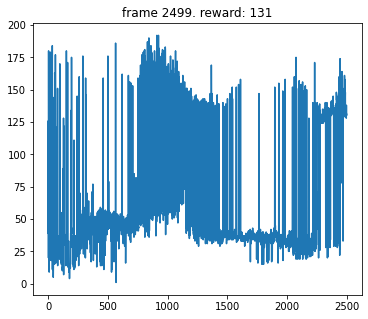

In [20]:
import gym
import sys
sys.path.append("/home/baiming/highway_multiagent_env") 
sys.path.append("C://Users//baiming//Seafile//THUFile//Papers//highway_env_multiagent") 
import highway_env

from agent import Agent

import torch
from torch import optim
import numpy as np 

from tqdm import tnrange
# from utils import record_videos,  capture_intermediate_frames

import argparse
import torch
import time
import os
import numpy as np
from gym.spaces import Box, Discrete
from pathlib import Path
from torch.autograd import Variable
from tensorboardX import SummaryWriter
# from utils.make_env import make_env
from utils.buffer import ReplayBuffer
# from utils.env_wrappers import SubprocVecEnv, DummyVecEnv
from algorithms.maddpg import MADDPG

t = 0
returns = []
for ep_i in range(2500):
#     print("Episodes %i-%i of %i" % (ep_i + 1,
#                                     ep_i + 2,
#                                     200))
    obs = env.reset()
    # obs.shape = (n_rollout_threads, nagent)(nobs), nobs differs per agent so not tensor
    maddpg.prep_rollouts(device='gpu')
    
    explr_pct_remaining = max(0, 2000 - ep_i) / 2000
    maddpg.scale_noise(0.3 * explr_pct_remaining)
    maddpg.reset_noise()
    
    sum_reward = 0

    agent_obs = []
    for i in range(4):
        agent_obs.append(np.array([obs[i%4], obs[(i+1)%4], obs[(i+2)%4], obs[(i+3)%4]]).flatten())
    obs = np.array([agent_obs])

    for et_i in range(100):
#         print(obs)
        torch_obs = [torch.FloatTensor(np.vstack(obs[:, i])) for i in range(maddpg.nagents)]
#         print(torch_obs)
        torch_agent_actions = maddpg.step(torch_obs, explore=True)
        # convert actions to numpy arrays
        agent_actions = [ac.data.numpy() for ac in torch_agent_actions]
        # rearrange actions to be per environment
        actions = [np.argmax(agent_actions[i][0]) for i in range(4)]
#         print(actions)
        next_obs, rewards, dones, infos = env.step(actions)
#         print(infos)
        sum_reward += rewards[0][0]
#         print(obs, agent_actions, rewards, next_obs, dones)
#         print(type(obs))
        replay_buffer.push(obs, agent_actions, rewards, next_obs, dones)
        if dones[0][0]:
            break
        obs = next_obs
        t += 1
        if (len(replay_buffer) >= 256 and (t % 20) < 1):
            if True:
                maddpg.prep_training(device='gpu')
            else:
                maddpg.prep_training(device='cpu')
            for u_i in range(1):

                for a_i in range(maddpg.nagents): 
                    sample = replay_buffer.sample(256,
                                                  to_gpu=True)
                    maddpg.update(sample, a_i, logger=logger)
                maddpg.update_all_targets()
                maddpg.prep_rollouts(device='gpu')
#     ep_rews = replay_buffer.get_average_rewards(100)
    returns.append(sum_reward)
#     print(sum_reward)
    
#     print(ep_rews)
#     for a_i, a_ep_rew in enumerate(ep_rews):
#         # logger.add_scalar('agent%i/mean_episode_rewards' % a_i, a_ep_rew, ep_i)
#         logger.add_scalars('agent%i/mean_episode_rewards' % a_i, {'reward': a_ep_rew}, ep_i)

#     if ep_i % config.save_interval < config.n_rollout_threads:
#         os.makedirs(run_dir / 'incremental', exist_ok=True)
#         maddpg.save(run_dir / 'incremental' / ('model_ep%i.pt' % (ep_i + 1)))
#         maddpg.save(run_dir / 'model.pt')
    plot(ep_i, returns)
# maddpg.save(run_dir / 'model.pt')
env.close()
# logger.export_scalars_to_json(str(log_dir / 'summary.json'))
# logger.close()

# obs, reward, terminal, info

In [21]:
maddpg.save(run_dir / 'model.pt')

In [ ]:
    model_path = (Path('./models') / config.env_id / config.model_name /
                  ('run%i' % config.run_num))
    if config.incremental is not None:
        model_path = model_path / 'incremental' / ('model_ep%i.pt' %
                                                   config.incremental)
    else:
        model_path = model_path / 'model.pt'

    if config.save_gifs:
        gif_path = model_path.parent / 'gifs'
        gif_path.mkdir(exist_ok=True)

    maddpg = MADDPG.init_from_save(model_path)

In [ ]:
env = gym.make("intersection-multiagent-v0")
model_path = (Path('./models') / config.env_id / config.model_name /
              ('run%i' % config.run_num))
if config.incremental is not None:
    model_path = model_path / 'incremental' / ('model_ep%i.pt' %
                                               config.incremental)
else:
    model_path = model_path / 'model.pt'

if config.save_gifs:
    gif_path = model_path.parent / 'gifs'
    gif_path.mkdir(exist_ok=True)

maddpg = MADDPG.init_from_save(model_path)

t = 0
returns = []
for ep_i in range(2500):
    obs = env.reset()
    maddpg.prep_rollouts(device='gpu')
    sum_reward = 0
    agent_obs = []
    for i in range(4):
        agent_obs.append(np.array([obs[i%4], obs[(i+1)%4], obs[(i+2)%4], obs[(i+3)%4]]).flatten())
    obs = np.array([agent_obs])

    for et_i in range(100):
        torch_obs = [torch.FloatTensor(np.vstack(obs[:, i])) for i in range(maddpg.nagents)]
        torch_agent_actions = maddpg.step(torch_obs, explore=False)
        agent_actions = [ac.data.numpy() for ac in torch_agent_actions]
        actions = [np.argmax(agent_actions[i][0]) for i in range(4)]
        next_obs, rewards, dones, infos = env.step(actions)
        sum_reward += rewards[0][0]
        if dones[0][0]:
            break
        obs = next_obs
        t += 1
    returns.append(sum_reward)
env.close()